<a href="https://colab.research.google.com/github/iyed-01/Fake-News-Detection/blob/main/FakeNews_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
import sys
sys.path.append('/content/gdrive/My Drive/fake_news_detection!')

In [9]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=4d393bba2731f42507f7f5f9ef12ec5b93bb6593e2462d7ffe330f7e489140fe
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [10]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
import nltk#####

from nltk.corpus import stopwords####
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import gensim
import warnings


# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
from wordcloud import WordCloud, STOPWORDS


/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [11]:
#remove punctuation
def remove_punct(text):
  list = [char for char in text if char not in string.punctuation]
  clean_str = ''.join(list)
  return clean_str



# Ngram analysis function
#https://github.com/AndriiShchur/Fake_news/blob/master/01_EDA.ipynb
 #
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]


#preprocess for "gensim.models.Lda" function
def preprocess(df,column):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df[column]:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

# Helper function used with LDA (sklearn)
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
            
# Function for word cloud


def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

In [12]:
warnings.simplefilter("ignore", DeprecationWarning)

In [13]:
np.random.seed(44)

In [14]:
nltk.download('stopwords')
stop = stopwords.words('english')
# ################# Preprocess function for LDA###########
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Understand the data

In [15]:

df = pd.read_csv('/content/gdrive/My Drive/fake_news_detection/news.csv')


In [16]:
print('dataframe shape:' ,df.shape)
df.head()

dataframe shape: (6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [17]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

We don't have a NaN  value. Otherwise, we can replace a NaN value in 'text' column with the title and vice versa.


In [18]:
#replace na
#df['text'] = df['text'].replace(np.nan, df['title'])
#df['title'] = df['title'].replace(np.nan, df['text'])

In [19]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

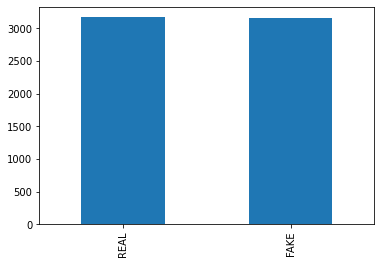

In [20]:
df['label'].value_counts().plot(kind = "bar", stacked=True)

We notice that our data is equidistributed (i.e the number of fake news(3171) is very close to the number of real news (3164)).

NB: if it's not the case, we should use "StratifiedShuffleSplit(StratifiedKFold)" from "sklearn.model_selection" to split our data into train and test set.

In [21]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


we will not use the column 'Unnamed: 0'

In [22]:
df.drop(['Unnamed: 0'], axis=1, inplace = True)

In [23]:
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [24]:
df['title_length'] = [len(str(i)) for i in df['title']]
df['title_length'].describe()

count    6335.000000
mean       65.277664
std        23.733657
min         1.000000
25%        49.000000
50%        64.000000
75%        78.000000
max       289.000000
Name: title_length, dtype: float64

In [25]:
df['text_length'] = [len(str(i)) for i in df['text']]
df['text_length'].describe()

count      6335.000000
mean       4707.250355
std        5090.956446
min           1.000000
25%        1741.500000
50%        3642.000000
75%        6192.000000
max      115372.000000
Name: text_length, dtype: float64

In [26]:
df.describe()

,title_length,text_length
count,6335.000000,6335.000000
mean,65.277664,4707.250355
std,23.733657,5090.956446
min,1.000000,1.000000
25%,49.000000,1741.500000
50%,64.000000,3642.000000
75%,78.000000,6192.000000
max,289.000000,115372.000000


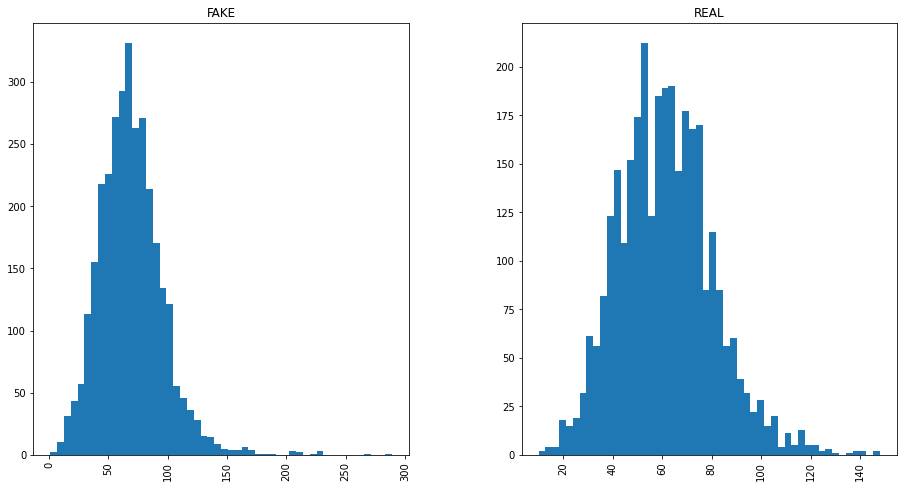

In [27]:
#  the number of characters present in each title by labels
df['title'].str.len().hist(by=df['label'],figsize =(15,8),bins=50)
plt.show()

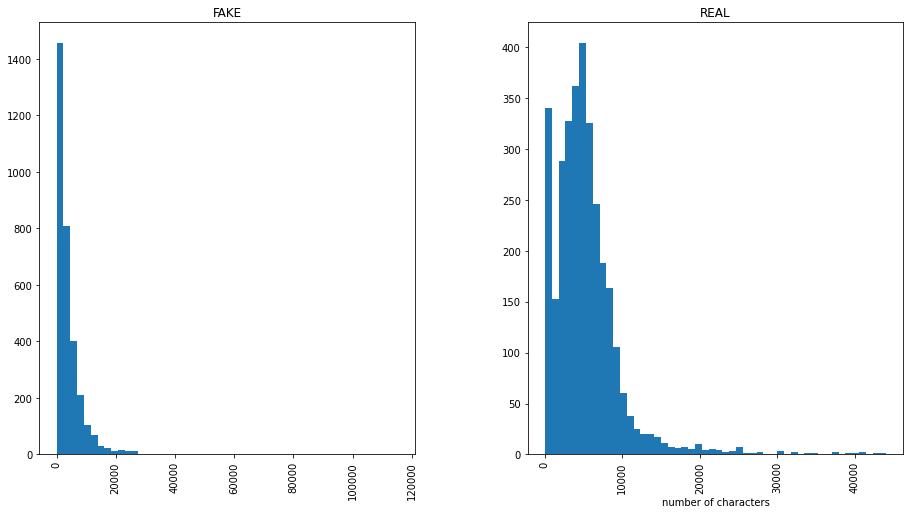

In [28]:
#  the number of characters present in each text by labels
df['text'].str.len().hist(by=df['label'],figsize =(15,8),bins=50)
plt.xlabel('number of characters')

plt.show()

## Clean Data


we will perform some simple preprocessing on the titles in order to make them more amenable for analysis. We will use a regular expression to remove stopwords and any punctuation in the title. Then we will perform lowercasing.

Remove stopwords

In [29]:

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Remove punctuation

In [31]:
df.text = df.text.apply(remove_punct)
df.title = df.title.apply(remove_punct)

lowercase

In [32]:
# Convert the titles to lowercase
df.title= df['title'].map(lambda x: x.lower())


In [33]:
# Convert the text to lowercase
df.text = df['text'].map(lambda x: x.lower())

In [34]:
df.text

0       daniel greenfield shillman journalism fellow f...
1       google pinterest digg linkedin reddit stumbleu...
2       us secretary state john f kerry said monday st...
3       — kaydee king kaydeeking november 9 2016 the l...
4       its primary day new york frontrunners hillary ...
                              ...                        
6330    the state department told republican national ...
6331    the ‘p’ pbs should stand ‘plutocratic’ ‘pentag...
6332    antitrump protesters are tools oligarchy refo...
6333    addis ababa ethiopia —president obama convened...
6334    jeb bush is suddenly attacking trump heres why...
Name: text, Length: 6335, dtype: object

##data visualisation






To get an overall idea of what data are we treating and what are the most frequent words that will be encoutered, it is best to visualize them in simple method.

In [35]:
#fake_text

fake_text = df.text.loc[df['label']=='FAKE'].str.split()
fake_text = fake_text.values.tolist()
corpus_fake_text = [word for text in fake_text for word in text]
counter_fake = Counter(corpus_fake_text)
most_fake = counter_fake.most_common()
x_fake, y_fake = [], []
for word, count in most_fake[:50]:
   if (word not in stop):
        y_fake.append(word)
        x_fake.append(count)
 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


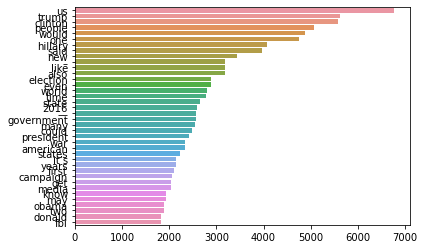

In [36]:
sns.barplot(x_fake,y_fake)
sns.set(rc={'figure.figsize':(15,15)})
plt.show()

In [37]:
#real_text
real_text = df.text.loc[df['label']=='REAL'].str.split()
real_text = real_text.values.tolist()
corpus_real_text = [word for text in fake_text for word in text]
counter_real = Counter(corpus_real_text)
most_real = counter_real.most_common()
x_real, y_real = [], []
for word, count in most_real[:50]:
   if (word not in stop):
        y_real.append(word)
        x_real.append(count)
 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


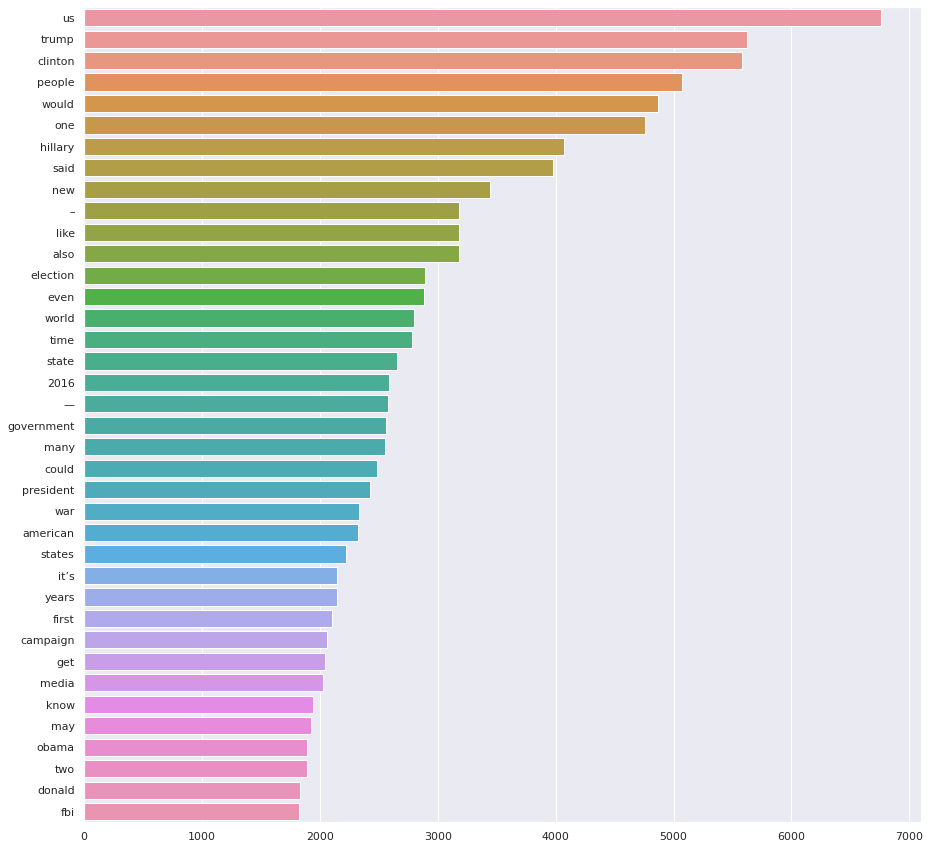

In [38]:
sns.barplot(x_real,y_real)
sns.set(rc={'figure.figsize':(15,15)})
plt.show()

In [39]:
#fake_title

fake_title = df.title.loc[df['label']=='FAKE'].str.split()
fake_title = fake_title.values.tolist()
corpus_fake_title = [word for text in fake_title for word in text]
counter_fake_title = Counter(corpus_fake_title)
most_fake_title = counter_fake_title.most_common()
x_fake_title, y_fake_title = [], []
for word, count in most_fake_title[:50]:
   if (word not in stop):
        y_fake_title.append(word)
        x_fake_title.append(count)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


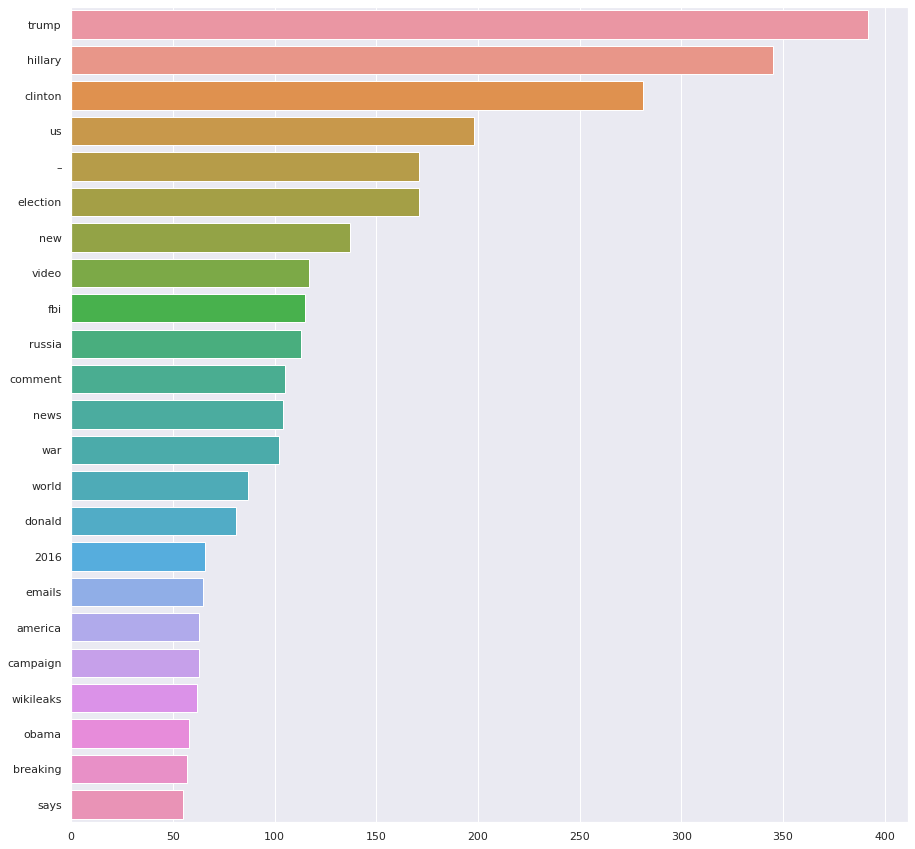

In [40]:
sns.barplot(x_fake_title,y_fake_title)
sns.set(rc={'figure.figsize':(15,15)})
plt.show()

In [41]:
#real_text

real_title = df.title.loc[df['label']=='REAL'].str.split()
real_title = real_title.values.tolist()
corpus_real_title = [word for text in fake_title for word in text]
counter_real_title = Counter(corpus_real_title)
most_real_title = counter_real.most_common()
x_real_title, y_real_title = [], []
for word, count in most_real_title[:50]:
   if (word not in stop):
        y_real_title.append(word)
        x_real_title.append(count)
 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


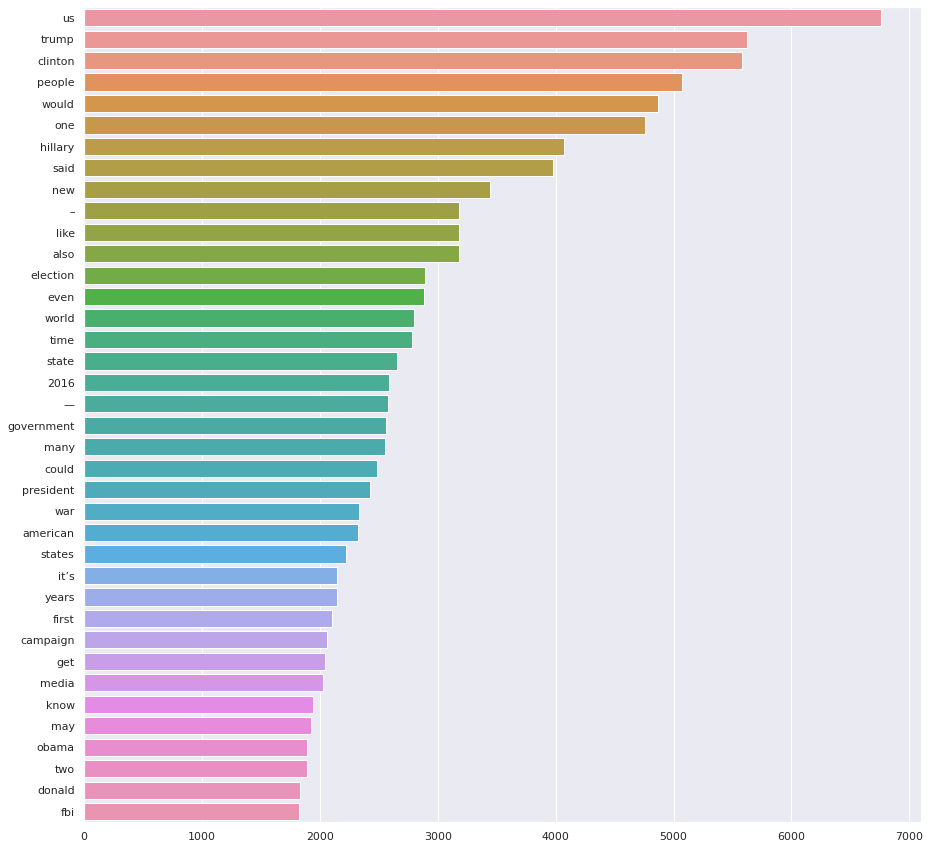

In [42]:
sns.barplot(x_real_title,y_real_title)
sns.set(rc={'figure.figsize':(15,15)})
plt.show()

# Ngram analysis function

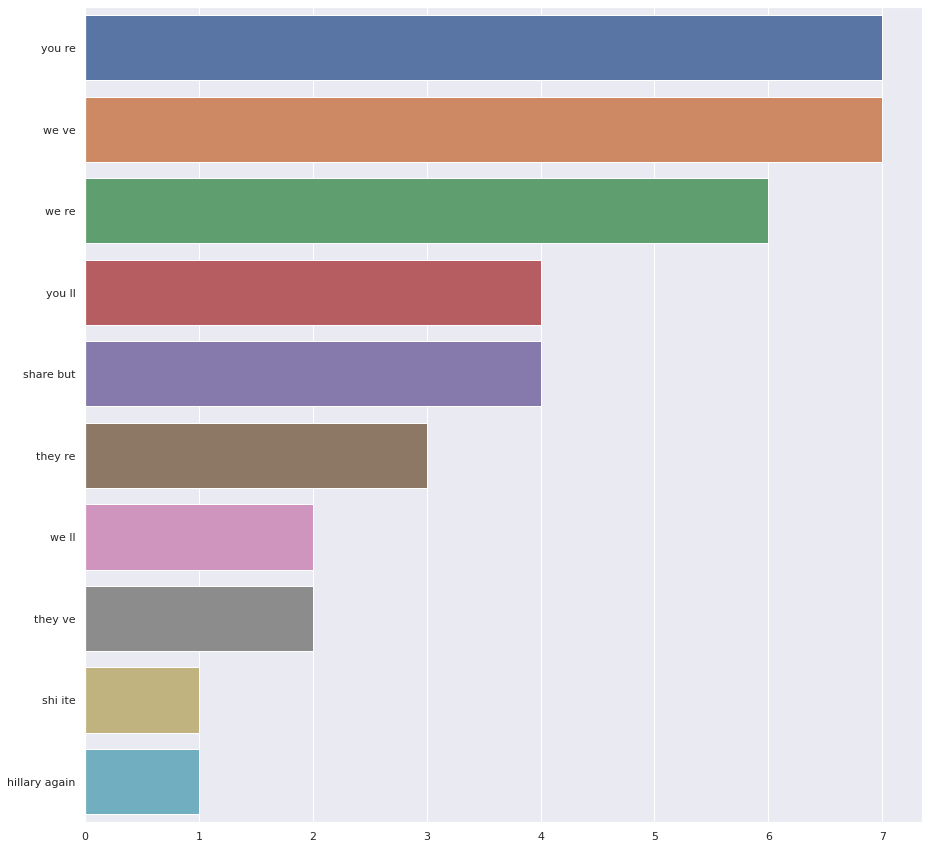

In [43]:
#2gram real title
top_n_bigrams=get_top_ngram(corpus_real_title,2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

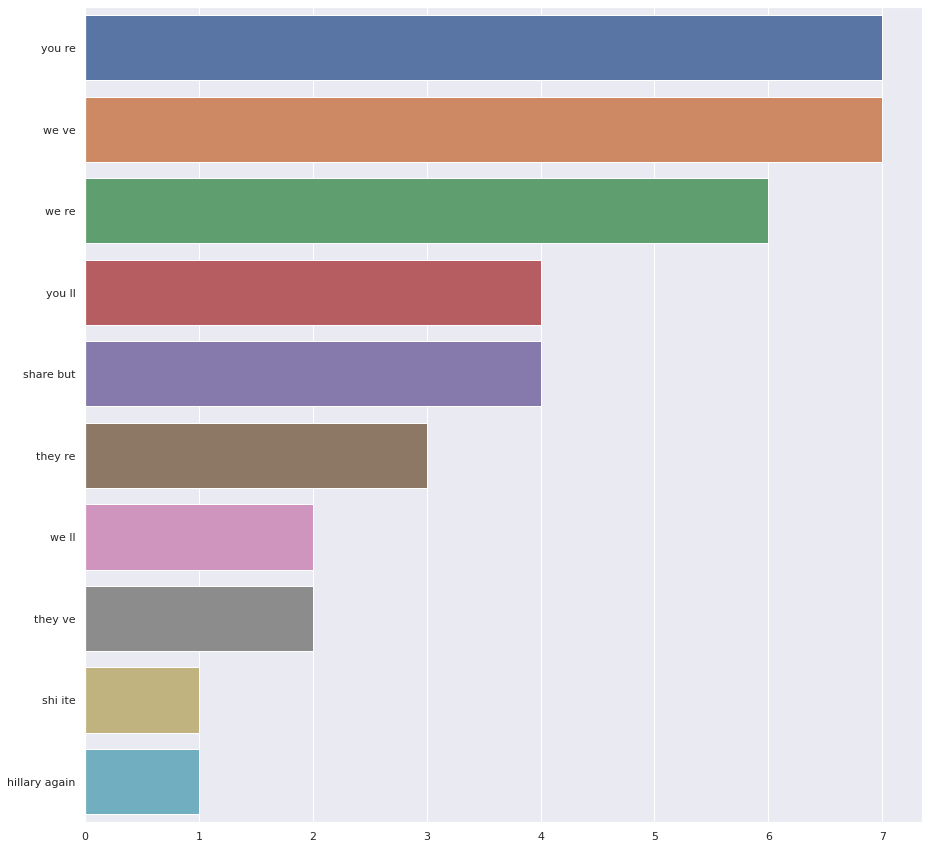

In [44]:
#2gram fake title
top_n_bigrams=get_top_ngram(corpus_fake_title,2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

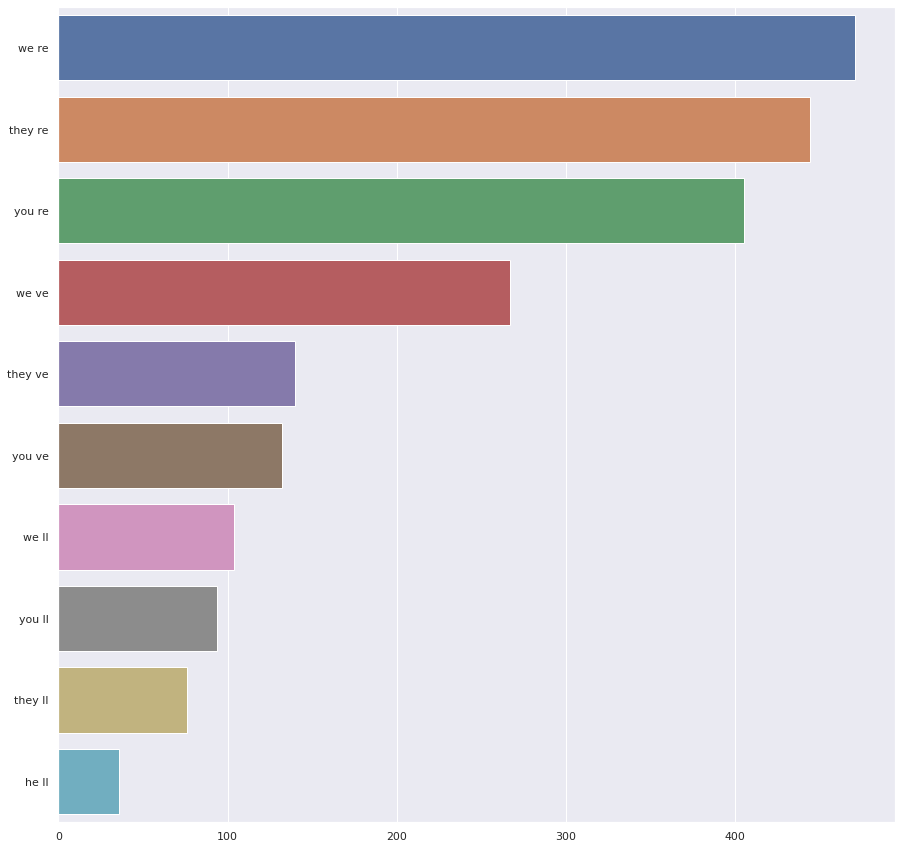

In [45]:
#2gram real text
top_n_bigrams=get_top_ngram(corpus_real_text,2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

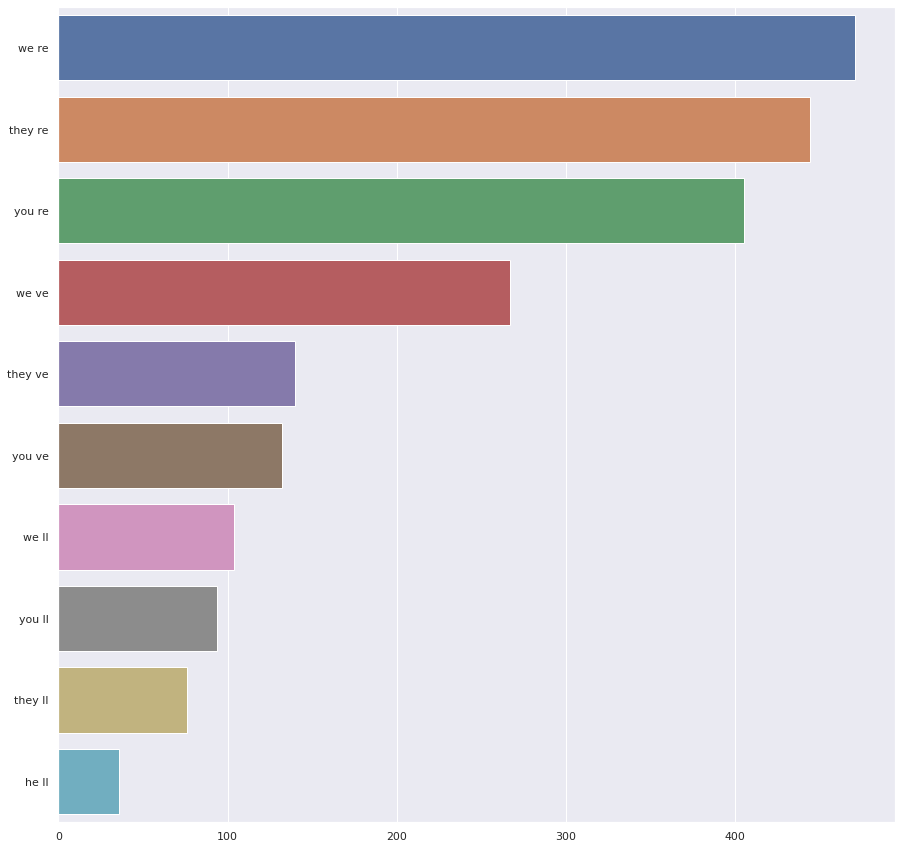

In [46]:
#2gram fake text
top_n_bigrams=get_top_ngram(corpus_fake_text,2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

#  Preprocess function for LDA

***Latent Dirichlet Allocation (LDA)***

LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, we will convert a list of titles into a list of vectors, all with length equal to the vocabulary. 

for further understanding of LDA check this link https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158

LDA documentation with genism library https://radimrehurek.com/gensim/models/ldamodel.html

In [47]:
#df with fake news 
fake_df = df[df.label == 'FAKE']
fake_df.head()

,title,text,label,title_length,text_length
0,you can smell hillary’s fear,daniel greenfield shillman journalism fellow f...,FAKE,28,7518
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE,85,2646
3,bernie supporters twitter erupt anger dnc we t...,— kaydee king kaydeeking november 9 2016 the l...,FAKE,84,2660
5,tehran usa,i’m immigrant grandparents are more 50 years a...,FAKE,11,13333
6,girl horrified at what she watches boyfriend d...,share this baylee luciani left screenshot bayl...,FAKE,73,3171


In [48]:
real_df = df[df.label == 'REAL']
real_df.head()

,title,text,label,title_length,text_length
2,kerry go paris gesture sympathy,us secretary state john f kerry said monday st...,REAL,43,2543
4,the battle new york why this primary matters,its primary day new york frontrunners hillary ...,REAL,48,1840
7,‘britain’s schindler’ dies 106,a czech stockbroker saved 650 jewish children ...,REAL,33,783
8,fact check trump clinton commanderinchief forum,hillary clinton donald trump made inaccurate c...,REAL,63,13863
9,iran reportedly makes new push uranium concess...,iranian negotiators reportedly made lastditch ...,REAL,71,4296


In [49]:
#LDA for corpus_title_fake
corpus = preprocess(fake_df,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics() 

[(0,
  '0.011*"hillary" + 0.007*"trump" + 0.006*"election" + 0.006*"russia" + 0.005*"new" + 0.004*"american" + 0.004*"say" + 0.003*"video" + 0.003*"make" + 0.003*"voter"'),
 (1,
  '0.026*"clinton" + 0.021*"hillary" + 0.010*"election" + 0.010*"email" + 0.009*"fbi" + 0.007*"america" + 0.007*"trump" + 0.007*"news" + 0.006*"wikileaks" + 0.006*"video"'),
 (2,
  '0.011*"trump" + 0.007*"comment" + 0.006*"hillary" + 0.006*"clinton" + 0.004*"government" + 0.004*"new" + 0.003*"state" + 0.003*"election" + 0.003*"video" + 0.003*"russian"'),
 (3,
  '0.030*"trump" + 0.012*"hillary" + 0.008*"donald" + 0.007*"clinton" + 0.006*"world" + 0.006*"war" + 0.006*"election" + 0.006*"new" + 0.005*"obama" + 0.004*"say"')]

output for fake title

(0,
  '0.019*"clinton" + 0.013*"trump" + 0.013*"hillary" + 0.006*"fbi" + 0.006*"comment" + 0.006*"new" + 0.005*"campaign" + 0.005*"email" + 0.005*"war" + 0.005*"video"'),
 (1,
  '0.017*"election" + 0.014*"trump" + 0.011*"hillary" + 0.006*"email" + 0.005*"win" + 0.004*"video" + 0.004*"clinton" + 0.003*"voting" + 0.003*"donald" + 0.003*"russia"'),
 (2,
  '0.020*"hillary" + 0.019*"trump" + 0.010*"clinton" + 0.008*"news" + 0.007*"election" + 0.007*"america" + 0.007*"russia" + 0.006*"world" + 0.005*"new" + 0.005*"fbi"'),
 (3,
  '0.011*"trump" + 0.009*"clinton" + 0.007*"hillary" + 0.005*"new" + 0.005*"russia" + 0.004*"wikileaks" + 0.004*"world" + 0.003*"one" + 0.003*"israel" + 0.003*"election"')

In [50]:
#LDA for corpus_title_real
corpus = preprocess(real_df,'title')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.031*"trump" + 0.021*"gop" + 0.014*"debate" + 0.008*"cruz" + 0.008*"donald" + 0.007*"republican" + 0.007*"campaign" + 0.007*"could" + 0.006*"win" + 0.005*"iran"'),
 (1,
  '0.018*"clinton" + 0.014*"trump" + 0.012*"new" + 0.010*"hillary" + 0.009*"house" + 0.009*"republican" + 0.008*"donald" + 0.008*"obama" + 0.006*"sander" + 0.006*"debate"'),
 (2,
  '0.011*"bush" + 0.010*"trump" + 0.009*"jeb" + 0.009*"attack" + 0.006*"terror" + 0.006*"rubio" + 0.006*"2016" + 0.006*"police" + 0.006*"donald" + 0.005*"obama"'),
 (3,
  '0.033*"trump" + 0.028*"clinton" + 0.020*"obama" + 0.013*"hillary" + 0.012*"gop" + 0.007*"sander" + 0.006*"deal" + 0.006*"say" + 0.006*"donald" + 0.005*"republican"')]

output for real title

0,
  '0.041*"trump" + 0.019*"gop" + 0.016*"clinton" + 0.013*"donald" + 0.010*"2016" + 0.009*"hillary" + 0.009*"win" + 0.008*"republican" + 0.007*"could" + 0.007*"election"'),
 (1,
  '0.025*"clinton" + 0.016*"trump" + 0.015*"debate" + 0.011*"obama" + 0.010*"sander" + 0.008*"hillary" + 0.007*"state" + 0.007*"donald" + 0.006*"republican" + 0.006*"house"'),
 (2,
  '0.019*"trump" + 0.012*"clinton" + 0.011*"obama" + 0.009*"say" + 0.008*"debate" + 0.008*"gop" + 0.007*"cruz" + 0.007*"state" + 0.007*"bill" + 0.007*"senate"'),
 (3,
  '0.015*"obama" + 0.015*"trump" + 0.014*"iran" + 0.012*"new" + 0.010*"deal" + 0.008*"attack" + 0.008*"campaign" + 0.006*"clinton" + 0.006*"hillary" + 0.006*"republican"')

In [51]:
#LDA for corpus_text_real
corpus = preprocess(real_df,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.007*"republican" + 0.007*"percent" + 0.005*"party" + 0.005*"people" + 0.005*"state" + 0.005*"year" + 0.005*"would" + 0.005*"american" + 0.005*"one" + 0.004*"say"'),
 (1,
  '0.026*"clinton" + 0.010*"said" + 0.008*"sander" + 0.006*"state" + 0.005*"campaign" + 0.005*"would" + 0.005*"email" + 0.004*"president" + 0.004*"hillary" + 0.004*"democratic"'),
 (2,
  '0.025*"trump" + 0.013*"said" + 0.007*"campaign" + 0.007*"republican" + 0.006*"state" + 0.005*"clinton" + 0.005*"candidate" + 0.005*"cruz" + 0.005*"one" + 0.005*"new"'),
 (3,
  '0.014*"said" + 0.008*"state" + 0.006*"obama" + 0.006*"would" + 0.006*"president" + 0.004*"house" + 0.004*"iran" + 0.004*"one" + 0.004*"also" + 0.003*"year"')]

output for real text


(0,
  '0.018*"clinton" + 0.009*"said" + 0.007*"trump" + 0.007*"state" + 0.006*"email" + 0.004*"one" + 0.004*"bush" + 0.004*"campaign" + 0.004*"would" + 0.004*"people"'),
 (1,
  '0.019*"said" + 0.006*"police" + 0.006*"state" + 0.004*"people" + 0.004*"attack" + 0.004*"official" + 0.004*"one" + 0.004*"also" + 0.003*"obama" + 0.003*"would"'),
 (2,
  '0.007*"said" + 0.007*"would" + 0.006*"state" + 0.005*"obama" + 0.005*"president" + 0.005*"people" + 0.005*"year" + 0.004*"republican" + 0.004*"american" + 0.004*"one"'),
 (3,
  '0.022*"trump" + 0.011*"clinton" + 0.011*"said" + 0.008*"republican" + 0.008*"campaign" + 0.006*"state" + 0.006*"party" + 0.006*"candidate" + 0.006*"sander" + 0.005*"voter"')

In [52]:
#LDA for corpus_text_fake
corpus = preprocess(fake_df,'text')
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.005*"people" + 0.005*"one" + 0.004*"state" + 0.004*"would" + 0.004*"year" + 0.004*"world" + 0.003*"government" + 0.003*"time" + 0.003*"also" + 0.003*"new"'),
 (1,
  '0.004*"said" + 0.004*"syria" + 0.004*"would" + 0.004*"russian" + 0.004*"one" + 0.004*"russia" + 0.003*"2016" + 0.003*"force" + 0.003*"war" + 0.003*"time"'),
 (2,
  '0.018*"clinton" + 0.010*"hillary" + 0.009*"email" + 0.007*"fbi" + 0.006*"election" + 0.006*"trump" + 0.005*"campaign" + 0.004*"investigation" + 0.004*"said" + 0.004*"would"'),
 (3,
  '0.011*"trump" + 0.006*"people" + 0.005*"clinton" + 0.005*"one" + 0.005*"state" + 0.005*"american" + 0.004*"would" + 0.004*"hillary" + 0.004*"like" + 0.003*"time"')]

output for fake text

(0,
  '0.006*"state" + 0.006*"russia" + 0.005*"government" + 0.005*"war" + 0.004*"would" + 0.004*"russian" + 0.004*"country" + 0.004*"one" + 0.003*"world" + 0.003*"people"'),
 (1,
  '0.004*"people" + 0.004*"one" + 0.004*"said" + 0.003*"year" + 0.003*"also" + 0.003*"time" + 0.003*"would" + 0.003*"new" + 0.003*"many" + 0.002*"water"'),
 (2,
  '0.006*"clinton" + 0.005*"email" + 0.004*"one" + 0.004*"time" + 0.004*"said" + 0.004*"people" + 0.004*"fbi" + 0.004*"would" + 0.004*"year" + 0.003*"new"'),
 (3,
  '0.011*"trump" + 0.011*"clinton" + 0.008*"hillary" + 0.006*"people" + 0.005*"election" + 0.005*"one" + 0.005*"would" + 0.004*"american" + 0.004*"state" + 0.004*"like"')

***lda.show_topics():*** For num_topics number of topics, return num_words most significant words (10 words per topic, by default).

**we can fit LDA with sklearn library also.** documentation https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [53]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
data_real_text = count_vectorizer.fit_transform(real_df.text)

        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(data_real_text)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
clinton trump sanders said campaign voters new republican percent democratic

Topic #1:
trump said campaign republican cruz donald people trumps like gop

Topic #2:
iran said nuclear iranian deal new pope cuba says sanctions

Topic #3:
president party obama political republicans republican democrats senate voters democratic

Topic #4:
said obama president state war military iraq bush isis foreign

Topic #5:
people states percent state americans health government black years like

Topic #6:
said court marriage law supreme case states justice state federal

Topic #7:
clinton said state hillary emails email department clintons campaign secretary

Topic #8:
said house obama congress deal president republicans senate new boehner

Topic #9:
said police people killed attack officers told attacks state shooting


In [54]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
data_fake_text = count_vectorizer.fit_transform(fake_df.text)

        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(data_fake_text)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
trump clinton hillary election campaign donald president said presidential vote

Topic #1:
state jewish arab time arabs land force 2016 british said

Topic #2:
health people cancer time like body use food years water

Topic #3:
gold news market years silver new world global price climate

Topic #4:
war israel government saudi syria people united states world new

Topic #5:
russia russian military war said syria forces nuclear china putin

Topic #6:
world new said trump state united people assange american states

Topic #7:
people pipeline water dakota state police zika standing north rock

Topic #8:
people trump like world government don time think america know

Topic #9:
clinton hillary fbi emails obama investigation comey email new election


In [55]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
data_real_title = count_vectorizer.fit_transform(real_df.title)

        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(data_real_title)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
presidential trump clinton gop donald candidates romney deal 2016 iran

Topic #1:
house white trump gop iran convention obama deal planned climate

Topic #2:
trump donald clinton hillary debate claims foreign trumps clintons policy

Topic #3:
cruz debate ted trump gop iowa clinton republican attack 2016

Topic #4:
house immigration john republicans white speaker gop christie kasich campaign

Topic #5:
trump donald new gop primary win sanders obama hampshire campaign

Topic #6:
clinton hillary obama sanders deal bernie iran campaign trump gop

Topic #7:
trump 2016 debate obama clinton politics things watch vote isis

Topic #8:
court supreme obama obamacare clinton marriage gay state case new

Topic #9:
clinton trump 2016 says obama bush jeb plan hillary campaign


In [56]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
data_fake_title = count_vectorizer.fit_transform(fake_df.title)

        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(data_fake_title)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
hillary clinton investigation new voters fbi breaking video trump election

Topic #1:
trump donald new clinton american fbi gold says obama world

Topic #2:
war clinton hillary russia election world 2016 trump putin russian

Topic #3:
clinton hillary trump election fbi wikileaks comment saudi new video

Topic #4:
trump vote putin hillary russia new america time fbi government

Topic #5:
trump clinton donald president fbi new hillary emails obama just

Topic #6:
trump election voter video fraud voting 2016 michael russia zika

Topic #7:
trump hillary election black america clinton video power comment going

Topic #8:
hillary source onion news finest americas trump comment russia isis

Topic #9:
hillary trump clinton news election wins day donald campaign russia


#wordcloud


In [57]:
stopwords = set(STOPWORDS)

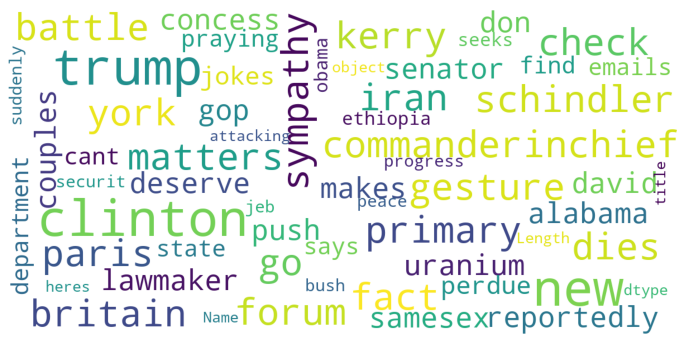

In [58]:
# Word cloud for title_real
show_wordcloud(real_df['title'])

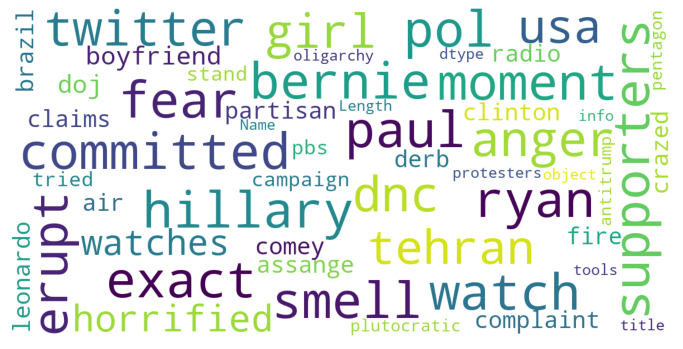

In [59]:
# Word cloud for title_
show_wordcloud(fake_df['title'])

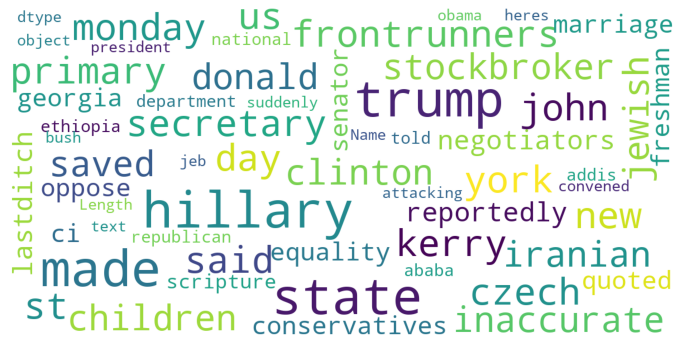

In [60]:
show_wordcloud(real_df['text'])

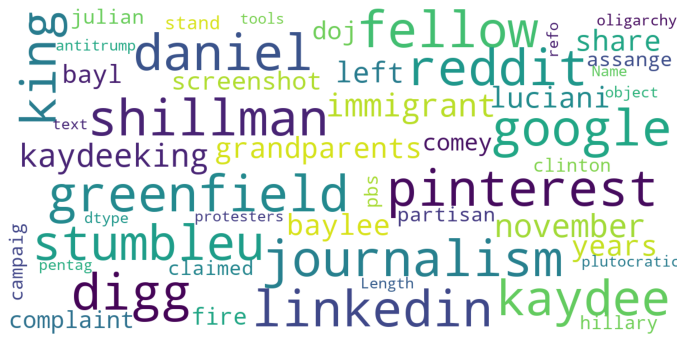

In [61]:
show_wordcloud(fake_df['text'])